In [ ]:
#step1
import pandas as pd

# Load CSV (make sure the path matches where your file is saved)
df = pd.read_csv("video_game_reviews.csv")

# Preview the dataset
print("Shape of dataset:", df.shape)
print("\nData types:\n", df.dtypes)

# Show the first few rows
df.head()


In [ ]:
# step2

# Describe user ratings
print("User Rating stats:\n", df['User Rating'].describe())

# Check missing values
print("\nMissing values per column:\n", df.isna().sum().sort_values(ascending=False))


In [ ]:
# step3

min_rating = df['User Rating'].min()
max_rating = df['User Rating'].max()

# Linear normalization to 1–5 scale
df['rating_1to5'] = 1 + 4 * ((df['User Rating'] - min_rating) / (max_rating - min_rating))

# Double-check the new scale
print("Normalized Rating stats:\n", df['rating_1to5'].describe())


In [ ]:
#step4
from scipy.sparse import csr_matrix
import pickle
import os

#Create synthetic user_id
df['user_id'] = df.index.astype(str)

#Normalize ratings again (1–5 scale)
min_rating = df['User Rating'].min()
max_rating = df['User Rating'].max()
df['rating_1to5'] = 1 + 4 * ((df['User Rating'] - min_rating) / (max_rating - min_rating))

#Pivot user-game matrix
ratings_matrix_df = df.pivot_table(index='user_id', columns='Game Title', values='rating_1to5')

#Keep only games with ≥10 ratings
valid_games = ratings_matrix_df.count() >= 10
ratings_matrix_df = ratings_matrix_df.loc[:, valid_games]

#Fill NaNs with 0 and convert to sparse matrix
sparse_matrix = csr_matrix(ratings_matrix_df.fillna(0))

# Save matrix to .pkl
os.makedirs("data/processed", exist_ok=True)
with open("data/processed/ratings_matrix.pkl", "wb") as f:
    pickle.dump(sparse_matrix, f)

print("Sparse ratings matrix saved as 'data/processed/ratings_matrix.pkl'")
print("Final shape (users x games):", sparse_matrix.shape)


In [ ]:
# step5
# Impute missing Price using platform-wise median
df['Price'] = df.groupby('Platform')['Price'].transform(lambda x: x.fillna(x.median()))

# Fill missing Genre with "Unknown"
df['Genre'] = df['Genre'].fillna("Unknown")

# Drop rows where more than 30% of the row is missing
row_threshold = int(0.3 * df.shape[1])
df = df[df.isnull().sum(axis=1) <= row_threshold]

# Verify no critical nulls remain
print("Remaining nulls after cleaning:\n")
print(df.isna().sum().sort_values(ascending=False))


In [ ]:
#Save cleaned metadata
df.to_csv("data/processed/meta_clean.csv", index=False)
print("Saved cleaned metadata to 'data/processed/meta_clean.csv'")


In [ ]:
import pandas as pd

# Load your cleaned data
df = pd.read_csv("data/processed/meta_clean.csv")

# Optional: preview
print(df.shape)
df[['User Review Text']].head()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import os

# STEP 9A: TF-IDF vectorization
tfidf = TfidfVectorizer(
    max_df=0.8,
    min_df=5,
    ngram_range=(1, 2),  # unigrams + bigrams
    stop_words='english'
)

# Apply on user reviews
tfidf_matrix = tfidf.fit_transform(df['User Review Text'])

# Check shape
print("TF-IDF matrix shape:", tfidf_matrix.shape)

# Save to file
os.makedirs("data/processed", exist_ok=True)
with open("data/processed/tfidf_full.pkl", "wb") as f:
    pickle.dump(tfidf_matrix, f)

print("Saved full TF-IDF matrix to data/processed/tfidf_full.pkl")


In [ ]:
from sklearn.decomposition import TruncatedSVD
import pickle

# Load the TF-IDF matrix
with open("data/processed/tfidf_full.pkl", "rb") as f:
    tfidf_matrix = pickle.load(f)

# Set n_components to something <= number of features (17)
svd = TruncatedSVD(n_components=17, random_state=42)
tfidf_svd_matrix = svd.fit_transform(tfidf_matrix)

# Confirm shape
print("TF-IDF SVD-reduced shape:", tfidf_svd_matrix.shape)

# Save result
with open("data/processed/tfidf_svd100.pkl", "wb") as f:
    pickle.dump(tfidf_svd_matrix, f)

print("Saved SVD-reduced TF-IDF matrix to data/processed/tfidf_svd100.pkl")


In [ ]:
#TODO later -  Run Word2Vec vectorization here (see Step 9B)
from gensim.models import Word2Vec
import numpy as np
import os

# Step 1: Tokenize text (basic whitespace split)
reviews_tokenized = df['User Review Text'].apply(lambda x: x.lower().split()).tolist()

# Step 2: Train Word2Vec model
w2v_model = Word2Vec(
    sentences=reviews_tokenized,
    vector_size=100,  # each word gets a 100-dim vector
    window=5,
    min_count=5,
    workers=4,
    sg=1,  # skip-gram model
    seed=42
)

# Step 3: Function to average word vectors per review
def get_avg_vector(tokens, model, vector_size):
    valid_vectors = [model.wv[word] for word in tokens if word in model.wv]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Step 4: Apply to each review
w2v_vectors = np.array([
    get_avg_vector(tokens, w2v_model, 100) for tokens in reviews_tokenized
])

# Step 5: Save the full matrix
os.makedirs("data/processed", exist_ok=True)
np.save("data/processed/w2v_full.npy", w2v_vectors)

print("Saved full Word2Vec document matrix to data/processed/w2v_full.npy")
print("Shape:", w2v_vectors.shape)


In [ ]:
import pandas as pd

# Load metadata (if not already in memory)
df = pd.read_csv("data/processed/meta_clean.csv")

# Step 11: One-hot encode Genre and Platform
genre_dummies = pd.get_dummies(df['Genre'], prefix='Genre')
platform_dummies = pd.get_dummies(df['Platform'], prefix='Platform')

# Combine with original dataframe
df_encoded = pd.concat([df, genre_dummies, platform_dummies], axis=1)

# Save updated metadata
df_encoded.to_csv("data/processed/meta_clean.csv", index=False)

print("Updated meta_clean.csv with one-hot encoded Genre and Platform.")
print("New shape:", df_encoded.shape)


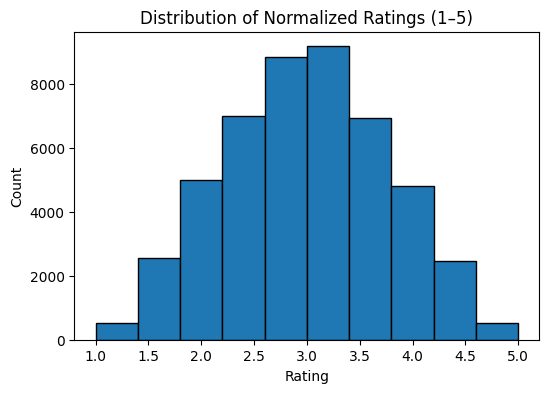

In [17]:
import matplotlib.pyplot as plt

# Histogram of normalized ratings
plt.figure(figsize=(6,4))
df['rating_1to5'].hist(bins=10, edgecolor='black')
plt.title("Distribution of Normalized Ratings (1–5)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(False)
plt.show()


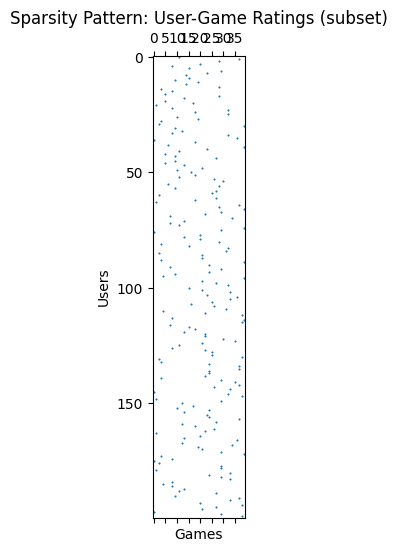

In [18]:
import pickle
import matplotlib.pyplot as plt

# Load ratings matrix
with open("data/processed/ratings_matrix.pkl", "rb") as f:
    ratings_matrix = pickle.load(f)

# Plot sparsity heatmap (small subset to make it visible)
plt.figure(figsize=(10,6))
plt.spy(ratings_matrix[:200, :40], markersize=0.5)
plt.title("Sparsity Pattern: User-Game Ratings (subset)")
plt.xlabel("Games")
plt.ylabel("Users")
plt.show()


c:\Python\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


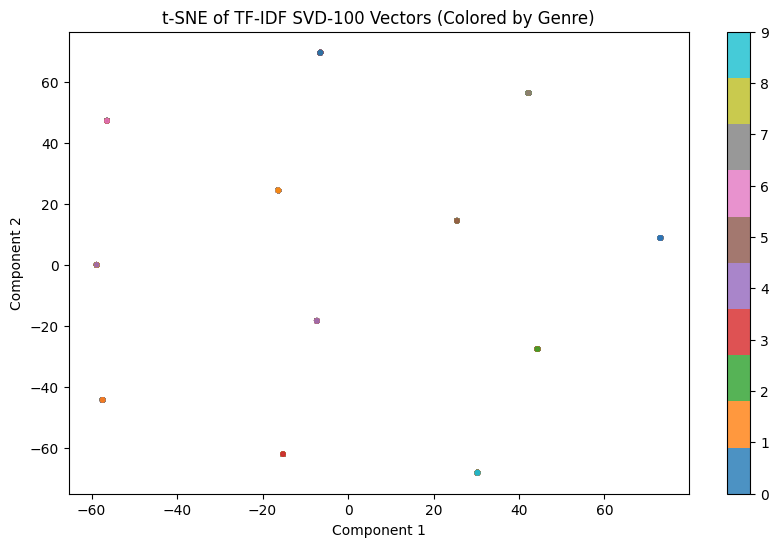

In [19]:
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Load reduced TF-IDF matrix
with open("data/processed/tfidf_svd100.pkl", "rb") as f:
    tfidf_svd = pickle.load(f)

# Load metadata with genre
df_meta = pd.read_csv("data/processed/meta_clean.csv")

# Apply t-SNE (slow!)
tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=500)
tsne_result = tsne.fit_transform(tfidf_svd)

# Plot with genre coloring (first 1000 for speed)
plt.figure(figsize=(10,6))
scatter = plt.scatter(
    tsne_result[:1000, 0],
    tsne_result[:1000, 1],
    c=pd.factorize(df_meta['Genre'][:1000])[0],
    cmap='tab10',
    s=10,
    alpha=0.8
)
plt.title("t-SNE of TF-IDF SVD-100 Vectors (Colored by Genre)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(scatter, ticks=range(10))
plt.show()
